In [2]:
!pip install pyspark
!pip install networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 20.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=4a02ec47a16171635dec2223b9de057d415ef86f2320192e8f6c2d0a8f197b26
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from pyspark import SparkConf
from pyspark.context import SparkContext
import time
import networkx as nx
import matplotlib.pyplot as plt
import random


In [4]:
def draw(rdd,nodes_to_color):
    G = nx.Graph()
    G.add_edges_from(rdd.collect())

    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_color='blue')
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos)

    # spécifiez la couleur pour un nœud spécifique
    node_to_color = {node: 'red' for node in nodes_to_color}
    for node, color in node_to_color.items():
        x, y = pos[node]
        plt.scatter(x, y, c=color, s=500, alpha=1)

    plt.show()
    
def generer_composantes_connexes(nb_composants_connexes,nb_noeud,nb_voisin_noeud):
    L=[]
    for i in range(nb_composants_connexes):
        k = nb_voisin_noeud   # nombre de voisins pour chaque noeud
        p = 0.5 # probabilité de réwiring
        # Attention  1 <= nb_voisin_noeud <= nb_noeud
        L.append(nx.connected_watts_strogatz_graph(nb_noeud,nb_voisin_noeud, p))
    G = nx.disjoint_union_all(L)
    
    if(nb_composants_connexes!=len(list(nx.connected_components(G)))):
        print("erreur de generation de composantes connexes")
    return list(G.edges)

In [5]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
#scd= SparkSession.builder.appName("Mon application").getOrCreate()

In [6]:
#df = scd.read.csv("data.csv", header=True, inferSchema=True)


In [7]:
def MapReduce_CFF_Iterate(rdd):
    #THE MAPPER ----
    mapped_rdd=rdd.flatMap(lambda x : (x,(x[1],x[0])))
    #SHUFFLE 
    grouped_rdd = mapped_rdd.groupByKey().map(lambda x : (x[0],list(x[1])))
    #REDUCER
    e1=grouped_rdd.map(lambda x: (x, min(x[1]+[x[0]])) ).filter(lambda x : x[1]<x[0][0])
    sortie1=e1.map(lambda x : (x[0][0],x[1]))
    sortie2=e1.map(lambda x :(list(set(x[0][1]).difference(set([x[1]]))),x[1])).flatMap(lambda x : list(zip(x[0],[x[1]]*len(x[0]))))
    Counter_New_Pair=sortie2.count()
    sortie=sortie2.union(sortie1).distinct() # Cette ligne illustre le CFF-Dedup grace au distinct qui enleve doublons
    return sortie,Counter_New_Pair


In [8]:
def MapReduce_CFF_Iterate_sorting(rdd):# with sorting
    #THE MAPPER ----
    mapped_rdd=rdd.flatMap(lambda x : (x,(x[1],x[0])))
    #SHUFFLE 
    grouped_rdd = mapped_rdd.groupByKey().map(lambda x : (x[0], sorted(list(x[1])+[x[0]])))# sort to respect sedonc approach
    #REDUCER
    e1=grouped_rdd.map(lambda x: (x,x[1][0] )).filter(lambda x : x[1]<x[0][0])
    sortie1=e1.map(lambda x : (x[0][0],x[1]))
    sortie2=e1.map(lambda x :(list(set(x[0][1]).difference(set([x[1]]+[x[0][0]]))),x[1])).flatMap(lambda x : list(zip(x[0],[x[1]]*len(x[0]))))
    Counter_New_Pair=sortie2.count()
    sortie=sortie2.union(sortie1).distinct() # Cette ligne illustre le CFF-Dedup grace au distinct qui enleve doublons
    return sortie,Counter_New_Pair

In [9]:
# VERSION 2 - with yield

def map_func(key, value):
    yield key, value
    yield value, key
    
def reduce_func(key, values):
    min_value = key
    value_list = []
    for value in values:
        if value < min_value:
            min_value = value
        value_list.append(value)
    if min_value < key:
        yield key, min_value ,0
        for value in value_list:
            if min_value != value:
                yield value, min_value,1
                
def reduce_func_sorting(key, values): 
    minValue = next(iter(values))
    if minValue < key:
        yield key, minValue ,0
        for value in values:
            if value != minValue:
                yield value, minValue,1
    

In [10]:
def MapReduce_CFF_Iterate_1(rdd):
    # THE MAPPER ----
    mapped_rdd = rdd.flatMap(lambda x: map_func(*x))
    # SHUFFLE 
    grouped_rdd = mapped_rdd.groupByKey().map(lambda x : (x[0],list(x[1])))
    #REDUCER
    reduced_rdd = grouped_rdd.flatMap(lambda x: reduce_func(*x))
    out_rdd = reduced_rdd.map(lambda x :(x[0],x[1])).distinct() # Cette ligne illustre le CFF-Dedup grace au distinct qui enleve doublons
    Counter_New_Pair = reduced_rdd.map(lambda x:x[2]).sum()
    return out_rdd , Counter_New_Pair

def MapReduce_CFF_Iterate_sorting_1(rdd):
    # THE MAPPER ----
    mapped_rdd = rdd.flatMap(lambda x: map_func(*x))
    # SHUFFLE 
    grouped_rdd = mapped_rdd.groupByKey().map(lambda x : (x[0],sorted(list(x[1])))) # sort to respect second approach
    #REDUCER
    reduced_rdd = grouped_rdd.flatMap(lambda x: reduce_func_sorting(*x))
    out_rdd = reduced_rdd.map(lambda x :(x[0],x[1])).distinct() # Cette ligne illustre le CFF-Dedup grace au distinct qui enleve doublons
    Counter_New_Pair = reduced_rdd.map(lambda x:x[2]).sum()
    return out_rdd , Counter_New_Pair

In [11]:
def Algo_main(f,rdd):
    debut = time.perf_counter()
    sortie,Counter_New_Pair=f(rdd)
    cmpt=Counter_New_Pair
    L=[(sortie,Counter_New_Pair)]
    iteration =1
    while Counter_New_Pair>0:
        iteration =iteration+1
        sortie,Counter_New_Pair=f(sortie)
        cmpt=cmpt+Counter_New_Pair
        L.append((sortie,Counter_New_Pair))
    fin = time.perf_counter()
    temps_execution = fin - debut
    final_sortie=sortie.map(lambda x : x[1]).distinct().collect()
    info ={"nb_iteration":iteration,"temps_execution":temps_execution,"count":cmpt,"nb_composants_conectés":len(final_sortie),"iteration_algo":L,"cles_composants_conectés":final_sortie,"rdd_depart":rdd }
    return info
    
    

In [12]:
def Afficher(T):
    T1=T
    T=T['iteration_algo']
    for i in range(len(T)):
        tmp= T[i][0].sortByKey()
        print("Itération ",i,":\n",tmp.collect()," | New Pair = ",T[i][1])
    print("\nTemps d'Execution Total : ",T1['temps_execution'])
    print("\nLe nombre de composants connecté est : ",T1['nb_composants_conectés']," , et voici leur clés : ",T1['cles_composants_conectés'])
    draw(T1['rdd_depart'],T1['cles_composants_conectés'])
    


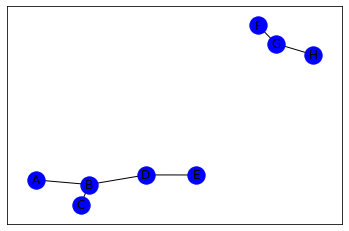

In [13]:
# Choix du RDD
rdd = sc.parallelize([("A", "B"), ("B", "C"), ("B", "D"),("D", "E"),("F","G"),("G","H")])
draw(rdd,[])

Itération  0 :
 [('B', 'A'), ('C', 'A'), ('C', 'B'), ('D', 'A'), ('D', 'B'), ('E', 'D'), ('E', 'B'), ('G', 'F'), ('H', 'F'), ('H', 'G')]  | New Pair =  4
Itération  1 :
 [('B', 'A'), ('C', 'A'), ('D', 'A'), ('D', 'B'), ('E', 'A'), ('E', 'B'), ('G', 'F'), ('H', 'F')]  | New Pair =  9
Itération  2 :
 [('B', 'A'), ('C', 'A'), ('D', 'A'), ('E', 'A'), ('G', 'F'), ('H', 'F')]  | New Pair =  4
Itération  3 :
 [('B', 'A'), ('C', 'A'), ('D', 'A'), ('E', 'A'), ('G', 'F'), ('H', 'F')]  | New Pair =  0

Temps d'Execution Total :  7.044926911999937

Le nombre de composants connecté est :  2  , et voici leur clés :  ['F', 'A']


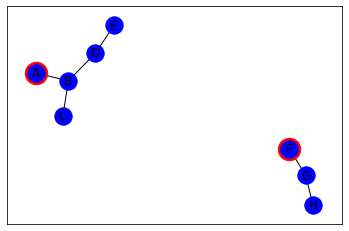

In [14]:
Afficher(Algo_main(MapReduce_CFF_Iterate,rdd))

Itération  0 :
 [('B', 'A'), ('C', 'A'), ('C', 'B'), ('D', 'A'), ('D', 'B'), ('E', 'D'), ('E', 'B'), ('G', 'F'), ('H', 'F'), ('H', 'G')]  | New Pair =  4
Itération  1 :
 [('B', 'A'), ('C', 'A'), ('D', 'A'), ('D', 'B'), ('E', 'A'), ('E', 'B'), ('G', 'F'), ('H', 'F')]  | New Pair =  9
Itération  2 :
 [('B', 'A'), ('C', 'A'), ('D', 'A'), ('E', 'A'), ('G', 'F'), ('H', 'F')]  | New Pair =  4
Itération  3 :
 [('B', 'A'), ('C', 'A'), ('D', 'A'), ('E', 'A'), ('G', 'F'), ('H', 'F')]  | New Pair =  0

Temps d'Execution Total :  4.503343524999991

Le nombre de composants connecté est :  2  , et voici leur clés :  ['F', 'A']


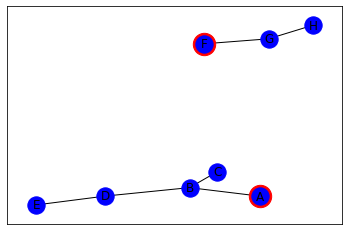

In [15]:
Afficher(Algo_main(MapReduce_CFF_Iterate_sorting,rdd))

Itération  0 :
 [('B', 'A'), ('C', 'B'), ('C', 'A'), ('D', 'A'), ('D', 'B'), ('E', 'B'), ('E', 'D'), ('G', 'F'), ('H', 'F'), ('H', 'G')]  | New Pair =  4
Itération  1 :
 [('B', 'A'), ('C', 'A'), ('D', 'A'), ('D', 'B'), ('E', 'A'), ('E', 'B'), ('G', 'F'), ('H', 'F')]  | New Pair =  9
Itération  2 :
 [('B', 'A'), ('C', 'A'), ('D', 'A'), ('E', 'A'), ('G', 'F'), ('H', 'F')]  | New Pair =  4
Itération  3 :
 [('B', 'A'), ('C', 'A'), ('D', 'A'), ('E', 'A'), ('G', 'F'), ('H', 'F')]  | New Pair =  0

Temps d'Execution Total :  0.9012516520000418

Le nombre de composants connecté est :  2  , et voici leur clés :  ['A', 'F']


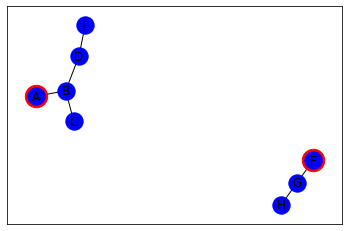

In [16]:
Afficher(Algo_main(MapReduce_CFF_Iterate_1,rdd))

Itération  0 :
 [('B', 'A'), ('C', 'B'), ('C', 'A'), ('D', 'A'), ('D', 'B'), ('E', 'B'), ('E', 'D'), ('G', 'F'), ('H', 'F'), ('H', 'G')]  | New Pair =  4
Itération  1 :
 [('B', 'A'), ('C', 'A'), ('D', 'A'), ('D', 'B'), ('E', 'A'), ('E', 'B'), ('G', 'F'), ('H', 'F')]  | New Pair =  9
Itération  2 :
 [('B', 'A'), ('C', 'A'), ('D', 'A'), ('E', 'A'), ('G', 'F'), ('H', 'F')]  | New Pair =  4
Itération  3 :
 [('B', 'A'), ('C', 'A'), ('D', 'A'), ('E', 'A'), ('G', 'F'), ('H', 'F')]  | New Pair =  0

Temps d'Execution Total :  0.9040672070000255

Le nombre de composants connecté est :  2  , et voici leur clés :  ['A', 'F']


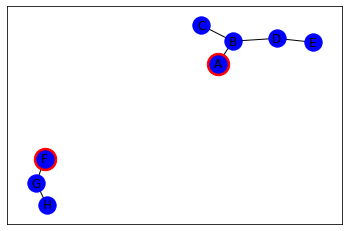

In [17]:
Afficher(Algo_main(MapReduce_CFF_Iterate_sorting_1,rdd))

In [ ]:
L_nb_noeud=list(range(10,1000,30))
T=[]
T_cff=[]
for n in L_nb_noeud:
    G=generer_composantes_connexes(int(n*0.4),n,int(n*0.2))
    T.append(G)
    T_cff.append(Algo_main(MapReduce_CFF_Iterate_sorting_1,sc.parallelize(G)))
    print('noeud : ',n,", edges : ",len(G),", nb composantes : ",int(n*0.4))
        

noeud :  10 , edges :  40 , nb composantes :  4
noeud :  40 , edges :  2560 , nb composantes :  16
noeud :  70 , edges :  13720 , nb composantes :  28
noeud :  100 , edges :  40000 , nb composantes :  40
noeud :  130 , edges :  87880 , nb composantes :  52


noeud :  160 , edges :  163840 , nb composantes :  64


noeud :  190 , edges :  274360 , nb composantes :  76


noeud :  220 , edges :  425920 , nb composantes :  88
23/02/13 13:13:39 WARN TaskSetManager: Stage 6141 contains a task of very large size (1211 KiB). The maximum recommended task size is 1000 KiB.


noeud :  250 , edges :  625000 , nb composantes :  100
23/02/13 13:13:51 WARN TaskSetManager: Stage 6171 contains a task of very large size (1708 KiB). The maximum recommended task size is 1000 KiB.


noeud :  280 , edges :  878080 , nb composantes :  112
23/02/13 13:14:06 WARN TaskSetManager: Stage 6201 contains a task of very large size (2324 KiB). The maximum recommended task size is 1000 KiB.


noeud :  310 , edges :  1191640 , nb composantes :  124
23/02/13 13:14:26 WARN TaskSetManager: Stage 6221 contains a task of very large size (3069 KiB). The maximum recommended task size is 1000 KiB.


noeud :  340 , edges :  1572160 , nb composantes :  136
23/02/13 13:14:51 WARN TaskSetManager: Stage 6241 contains a task of very large size (3951 KiB). The maximum recommended task size is 1000 KiB.


noeud :  370 , edges :  2026120 , nb composantes :  148
23/02/13 13:15:24 WARN TaskSetManager: Stage 6261 contains a task of very large size (5001 KiB). The maximum recommended task size is 1000 KiB.


noeud :  400 , edges :  2560000 , nb composantes :  160
23/02/13 13:16:06 WARN TaskSetManager: Stage 6291 contains a task of very large size (6212 KiB). The maximum recommended task size is 1000 KiB.


noeud :  430 , edges :  3180280 , nb composantes :  172


KeyboardInterrupt: 

In [ ]:
len(T_cff)

15

In [ ]:
T_time=[]
T_iter=[]
T_count=[]
for t in T_cff:
    T_time.append(t['temps_execution'])
    T_iter.append(t['nb_iteration'])
    T_count.append(t['count'])

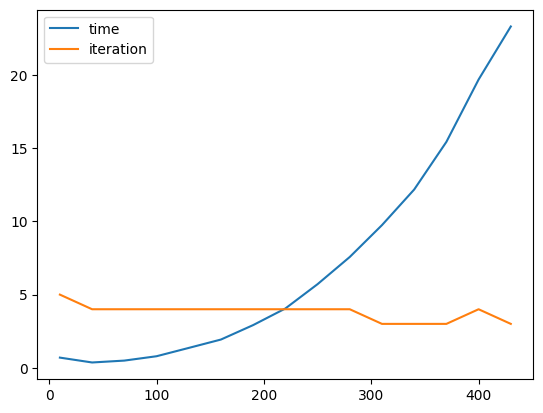

In [ ]:
x=L_nb_noeud[:15]
y1=T_time
y2=T_iter
y3=T_count
plt.plot(x, y1, label='time')
plt.plot(x, y2, label='iteration')
#plt.plot(x, y3, label='count')
plt.legend()
plt.show()

